# Generate data from ARIMA models
Running this notebook will:

- create 9 ARIMA models
- show and save plots of some data generated from these models
- generate more X samples and create a dataframe with true labels 
- save used models and generated data to pickle file

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import pickle
from ARIMA import *
from sacf import *
from model_class import *

DATA_DIR = "./generated_data"
GENERATING_MODEL_NAME = "ARIMA_statio"
N_TRAIN_SAMPLES_PER_MODEL = 5
N_TEST_SAMPLES_PER_MODEL = 30
MAX_SAMPLE_LEN = 50
MIN_SAMPLE_LEN = 20

FILENAME_SUFFIX = f"{GENERATING_MODEL_NAME}_data_ntrain{N_TEST_SAMPLES_PER_MODEL}"
DESCRIPTION = "ARIMA models but all are stationary (?)"

time_index = int(time.time())

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

## Define models

In [2]:
# Stationary, difference in mean (t) or in variance (theta)
model1 = ARIMA_model(np.array([0.8]), np.array([0.0]), t = 1)
model2 = ARIMA_model(np.array([0.8]), np.array([2.0]), t = 1)
model3 = ARIMA_model(np.array([0.8]), np.array([2.0]), t = 3)
# Divergent, difference in mean (t) or in variance (theta)
model4 = ARIMA_model(np.array([-1.01]), np.array([0.0]), t = 1)
model5 = ARIMA_model(np.array([-1.01]), np.array([4.0]), t = 1)
model6 = ARIMA_model(np.array([-1.01]), np.array([4.0]), t = 0)
# ARIMA (d > 0)
model7 = ARIMA_model(np.array([0.8]), np.array([0.0]), d = 1, t = 1)
model8 = ARIMA_model(np.array([0.8]), np.array([2.0]), d = 1, t = 1)
model9 = ARIMA_model(np.array([0.8]), np.array([2.0]), d = 1, t = 0)


models_lst = [model1, model2, model3, model4, model5, model6, model7, model8, model9]

## Show plots

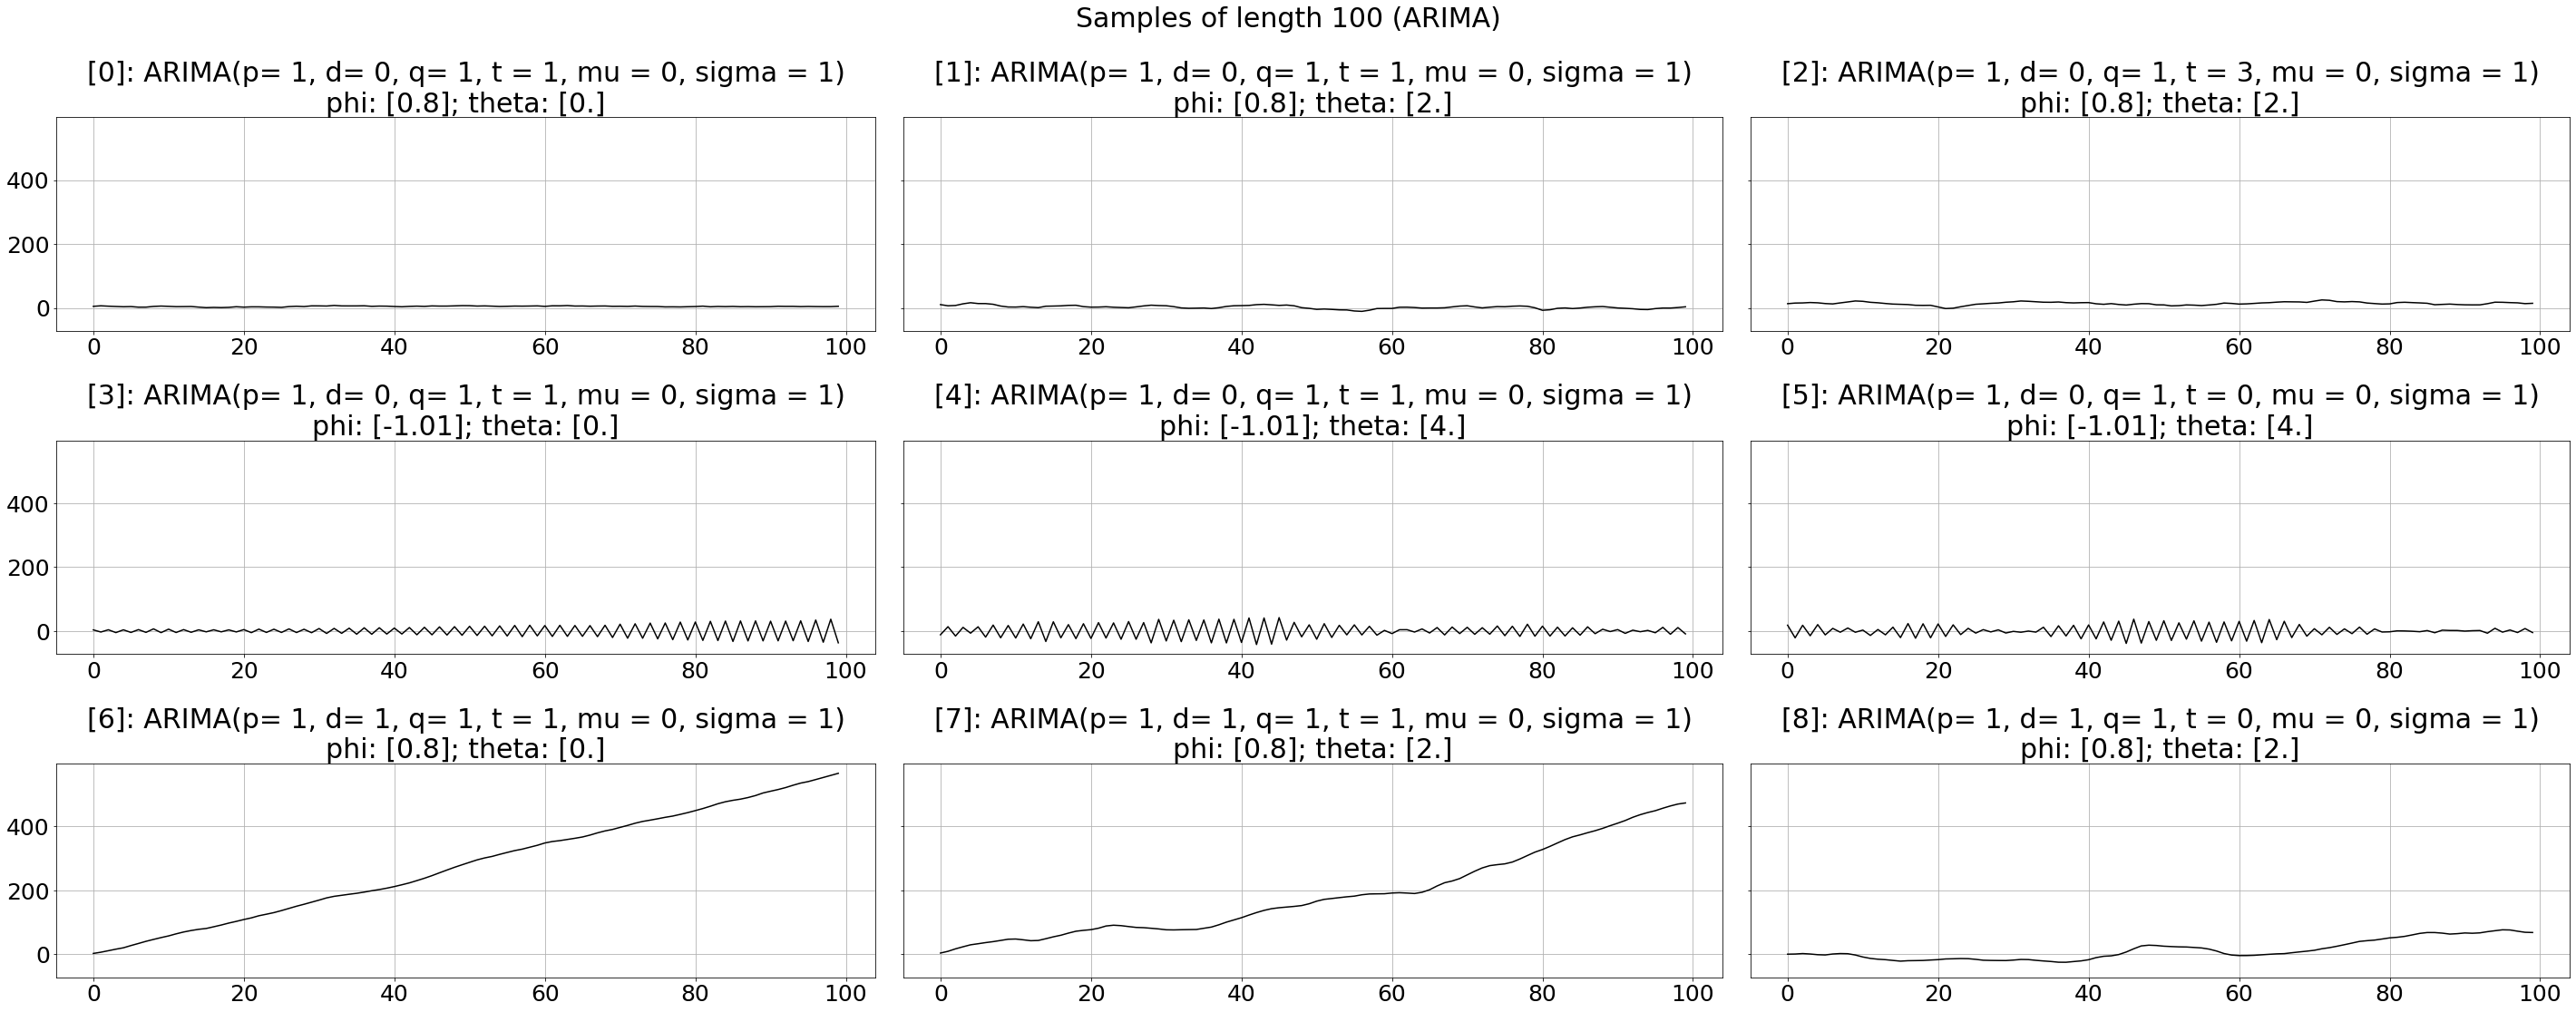

In [3]:
n = 100
plt.rcParams["figure.figsize"] = (40, 16)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(3,3, sharey="all")
plt.suptitle(f"Samples of length {n} (ARIMA)")
for i, ax in enumerate(axes.reshape(-1)):
    m = models_lst[i]
    try:
        X = m.sample(n)
    except Exception as e:
        print(f"Error in model {i}: {e}")
        continue
        
    ax.plot(X, color = "black")
    ax.set_title(f"[{i}]: ARIMA(p= {m.p}, d= {m.d}, q= {m.q}, t = {m.t}, mu = {m.mu}, sigma = {m.sigma})\nphi: {m.phi}; theta: {m.theta}")
    ax.grid()

fig.tight_layout()   
plt.savefig(f"./plots/models_ARIMA_{time_index}.jpg")
plt.show()

## Generate all data

In [4]:
def generate_data(models_lst: list[ARIMA_model], samples_per_model: int, max_sample_len: int, min_sample_len: int) -> tuple:
    """Generate data from list of hmm.BaseHMM instances.
    Returns:
        - labels_df: pd.DataFrame | sample_id | true_label | sample_len
        - all_X_samples: a list with generated X samples
    """
    all_X_samples = []
    true_labels = []
    sample_lengths = []
    sample_ids = list(range(samples_per_model*len(models_lst)))
    len_step = (max_sample_len-min_sample_len)//10
    possible_lenghts = range(min_sample_len, max_sample_len + 1, len_step)
    
    for i in range(len(models_lst)):
        model = models_lst[i]
        for j in range(samples_per_model):
            sample_len = np.random.choice(possible_lenghts)
            X = model.sample(sample_len)
            all_X_samples.append(X)
            sample_lengths.append(sample_len)
            true_labels.append(i)

    labels_df = pd.DataFrame({
        "sample_id": sample_ids,
        "true_label": true_labels,
        "sample_len": sample_lengths
    })

    return labels_df, all_X_samples

In [5]:
samples_per_model = N_TRAIN_SAMPLES_PER_MODEL + N_TEST_SAMPLES_PER_MODEL
labels_df, all_X_samples = generate_data(models_lst, samples_per_model, MAX_SAMPLE_LEN, MIN_SAMPLE_LEN)

## Prepare splits

In [6]:
train_samples_ids = []
test_samples_ids = []
for label, sub_df in labels_df.groupby("true_label"):
    train_ids = sub_df.sample(N_TRAIN_SAMPLES_PER_MODEL).index.values
    test_ids = sub_df.drop(train_ids).index.values
    if len(test_ids) != N_TEST_SAMPLES_PER_MODEL:
        raise Exception(f"len(test_ids) {len(test_ids)} != N_TEST_SAMPLES_PER_MODEL {N_TEST_SAMPLES_PER_MODEL}")
    train_samples_ids.extend(train_ids)
    test_samples_ids.extend(test_ids)
    

indices_split = {
    "train_samples_ids": train_samples_ids, 
    "test_samples_ids": test_samples_ids}

indices_splits_lst = [indices_split]
print(len(indices_split["train_samples_ids"]), len(indices_split["test_samples_ids"]))

45 270


In [7]:
data_filename = f"{FILENAME_SUFFIX}_{time_index}.pkl"
output_path = f"{DATA_DIR}/{data_filename}"

metadata = {
    "N_TRAIN_SAMPLES_PER_MODEL": N_TRAIN_SAMPLES_PER_MODEL,
    "N_TEST_SAMPLES_PER_MODEL": N_TEST_SAMPLES_PER_MODEL,
    "MAX_SAMPLE_LEN": MAX_SAMPLE_LEN,
    "MIN_SAMPLE_LEN": MIN_SAMPLE_LEN,
}

data = {
    'generating_model': GENERATING_MODEL_NAME,
    'data_filename': data_filename,
    'time_index': time_index,
    'models_lst': models_lst,
    'labels_df': labels_df,
    'all_X_samples': all_X_samples,
    'indices_splits_lst': indices_splits_lst,
    'metadata': metadata,
    'description': DESCRIPTION
}

with open(output_path, 'wb') as f:
    pickle.dump(data, f)
    print(f"Data saved to {output_path}.")

Data saved to ./generated_data/ARIMA_data_ntrain5_1658502456.pkl.
